# COVID-2019 Italy Cases Predictions Using Logistic Curves and Derivatives
## Tudor Gheorghiu, 9th of March, 2020

#### This notebook and statistics were inspired by [this paper](https://jmahaffy.sdsu.edu/courses/f07/math636/lectures/epidemics/epidemics.pdf) which explores the idea of predicting epidemic cases using mathematical models. [3blue1brown's newest video](https://www.youtube.com/watch?v=Kas0tIxDvrg) on logistic curves in epidemics also made me interested in trying out various models and try to predict confirmed cases in Italy, which took emergency measures yesterday, 8th of March. I really recommend watching the video before reading this notebook.

### Data Sources
* [time_series_19-covid-Confirmed.csv](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset)

### Tables of Contents:
1. Loading data and selecting specific data for China and Italy
2. Creating smoothed derivatives of the China cases and integrating them (hopefully, we will observe a logistic curve)
3. Finding "delay" of Italy cases and plotting the matching derivative curves.
4. Create a basic prediction for the Italy cases.
5. Results and Predictions


### 1. Loading data and selecting specific data for China and italy

The dataset I am using contains confirmed cases data from 22nd of January, 2020 to 8th of March, 2020. The dataset contains all of the affected countries, but we will only select China and italy.

In [1]:
import numpy as np
import pandas as pd

data = pd.read_csv("time_series_19-covid-Confirmed.csv")
print(data.shape)
data.head()

(255, 51)


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20
0,Anhui,Mainland China,31.8257,117.2264,1,9,15,39,60,70,...,990,990,990,990,990,990,990,990,990,990
1,Beijing,Mainland China,40.1824,116.4142,14,22,36,41,68,80,...,410,411,413,414,414,418,418,422,426,428
2,Chongqing,Mainland China,30.0572,107.8740,6,9,27,57,75,110,...,576,576,576,576,576,576,576,576,576,576
3,Fujian,Mainland China,26.0789,117.9874,1,5,10,18,35,59,...,296,296,296,296,296,296,296,296,296,296
4,Gansu,Mainland China,36.0611,103.8343,0,2,2,4,7,14,...,91,91,91,91,91,91,102,119,120,124


We can select only the wanted cases by choosing rows with "Mainland China" as its _Country/Region_ and performing a sum on the columns

In [2]:
china_y = []
italy_y = []

for j in range(4, 51): #These are the dates - on columns
    tempsum_china = 0
    tempsum_italy = 0
    for i in range(0, len(data)):
        if data.iloc[i, 1] == "Mainland China": #Check if the country is china
            tempsum_china = tempsum_china + data.iloc[i, j]
        if data.iloc[i, 1] == "Italy": #Check if the country is Italy
            tempsum_italy = tempsum_italy + data.iloc[i, j]
    china_y.append(tempsum_china)
    italy_y.append(tempsum_italy)
print("China cases up to 08/03/2020: {}".format(china_y[len(china_y) - 1]))
print("Italy cases up to 08/03/2020: {}".format(italy_y[len(italy_y) - 1]))

China cases up to 08/03/2020: 80699
Italy cases up to 08/03/2020: 7375


We can now plot the 2 countries and see how they compare

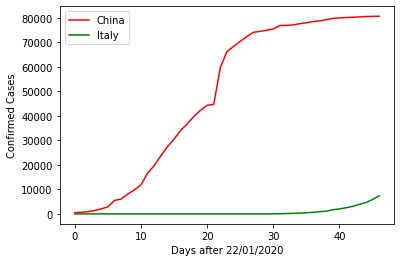

In [3]:
import matplotlib.pyplot as plt

plt.ylabel("Confirmed Cases")
plt.xlabel("Days after 22/01/2020")

plt.plot(china_y, color='red', label='China')
plt.plot(italy_y, color='green', label='Italy')
plt.legend()
plt.show()

It is clear that China is in a way worse situation than Italy, but as _3blue1brown_ mentioned in his video, this is just a "delay". We will address this delay when making predictions in a later step. We can also observe that China's line is similar to a sigmoid/logistic curve.

### 2. Creating smoothed derivatives of the China cases and integrating them (hopefully, we will observe a logistic curve)

First, we have to ask ourselves: why would we want to create and plot derivatives for this data? Well, if we think about how a logistic curve looks, the derivative of such a curve should look like a parabola, since the first half of a sigmoid function resembles an exponential curve. With such a curve, we can make predictions more easily, and then integrate it to get actual confirmed cases.

In order to create a smoothed derivative, we can use a [Savitzky-Golay filter](https://docs.scipy.org/doc/scipy-0.16.1/reference/generated/scipy.signal.savgol_filter.html) which is available in the _scipy_ library.

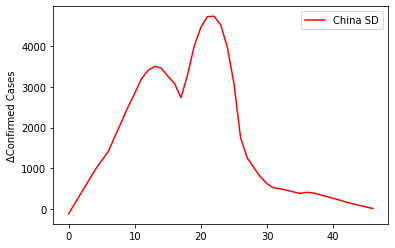

In [4]:
from scipy.signal import savgol_filter

deriv_china = savgol_filter(china_y, 9, 2, 1) #Polynomial degree is 2 since the function should look like a parabola

plt.ylabel("ΔConfirmed Cases")

plt.plot(deriv_china, color='red', label="China SD")
plt.legend()
plt.show()

This looks close to the desired result, but let's smooth the curve a little more.

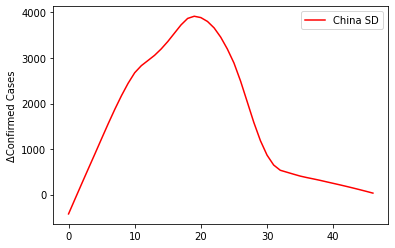

In [5]:
from scipy.signal import savgol_filter

deriv_china = savgol_filter(china_y, int(len(china_y)/3), 2, 1) #Polynomial degree is 2 since the function should look like a parabola
deriv_china = savgol_filter(deriv_china, int(len(china_y)/5), 2, 0)

plt.ylabel("ΔConfirmed Cases")

plt.plot(deriv_china, color='red', label="China SD")
plt.legend()
plt.show()

Great! Now we can integrate this function and compare it to actual cases, and it should be a good fit.

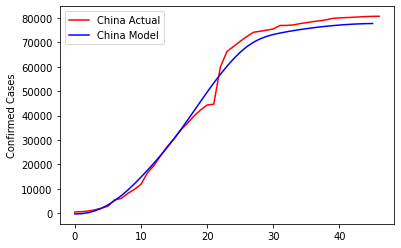

In [6]:
from scipy import integrate

china_y_pred = integrate.cumtrapz(deriv_china) 

plt.ylabel("Confirmed Cases")

plt.plot(china_y, color='red', label="China Actual")
plt.plot(china_y_pred, color='blue', label='China Model')
plt.legend()
plt.show()

The model is not perfect, but it should be good enough for estimations and predictions (± 2000 cases).

### 3. Finding "delay" of Italy cases and plotting the matching derivative curves.

Italy took emergency measures yesterday, when cases started rising rapidly. If we are looking at China's data, this means Italy is now at the start of the logistic curve (or the start of the parabola on the derivative). We can try to remove the days with low activity from the Italy data and match it with China's data.

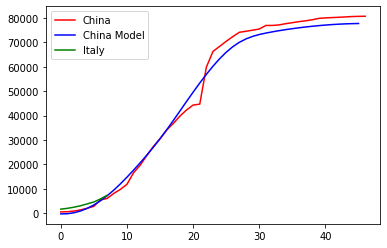

In [7]:
italy_y = italy_y[39:]
deriv_italy = savgol_filter(italy_y, 5, 2, 1)
deriv_italy = savgol_filter(deriv_italy, 3, 2, 0)

plt.plot(china_y, color='red', label='China')
plt.plot(china_y_pred, color='blue', label="China Model")
plt.plot(italy_y, color='green', label='Italy')
plt.legend()
plt.show()

It is clear that Italy is starting to follow China's trend. Let's also plot and compare the derivative plots

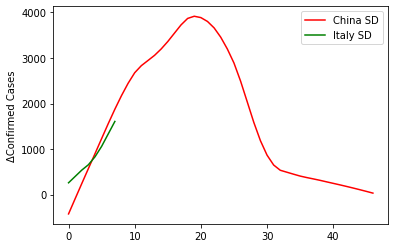

In [8]:
plt.ylabel("ΔConfirmed Cases")

plt.plot(deriv_china, color='red', label='China SD')
plt.plot(deriv_italy, color='green', label='Italy SD')
plt.legend()
plt.show()

### 4. Create a basic prediction for the Italy cases.

We now have to create a basic prediction model for the Italy cases. We do not have enough data to create a very accurate model, so we are going to use a different method. First, we will create this basic model which will closely resemble China's cases. Obviously, things will be different in Italy, that's why we will fine-tune the model in a later step.

In order to create a basic model we can further smooth the curve and shift it to match the already known Italy data.

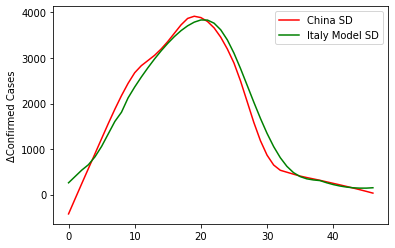

In [9]:
italy_derv_model = np.roll(deriv_china, 1)
italy_derv_model = savgol_filter(italy_derv_model, 17, 2, 0)
italy_basic_model= []
for i in range(8):
    italy_basic_model.append(deriv_italy[i])

for i in range(8, len(italy_derv_model)):
    italy_basic_model.append(italy_derv_model[i])

plt.ylabel("ΔConfirmed Cases")

plt.plot(deriv_china, color='red', label="China SD")
plt.plot(italy_basic_model, color='green', label='Italy Model SD')
plt.legend()
plt.show()

This is the basic model we have created for Italy. It is very simillar to China's. Let's see how Italy's cases would compare to China's cases (if this simple model would be accurate). Keep in mind, there is still that "delay", so Italy's is just at the start of the following graph:

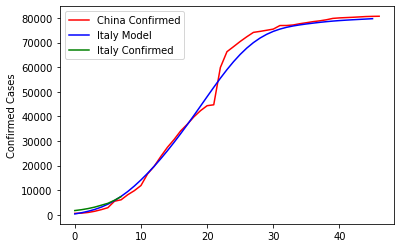

In [10]:
italy_basic_model_confirmed = integrate.cumtrapz(italy_basic_model)

plt.ylabel("Confirmed Cases")

plt.plot(china_y, color='red', label='China Confirmed')
plt.plot(italy_basic_model_confirmed, color='blue', label='Italy Model')
plt.plot(italy_y, color='green', label='Italy Confirmed')
plt.legend()
plt.show()

Italy took emergency measures yesterday, 8th of March, right at the beginning of the logistic curve. [Source](http://www.governo.it/it/articolo/coronavirus-firmato-il-dpcm-8-marzo-2020/14266)

China took emergency measures on 24th of January. [Source](https://www.sixthtone.com/news/1005135/shanghai-launches-level-1-emergency-response-over-coronavirus)

If we consider the delay, China and Italy both took the emergency measures right at the beginning of the logistic curve. I approximated the delay to be around **38 days** by matching and fitting the graphs. The difference in days between the emergency measures is **44**. This actually means that China took emergency measures about a week sooner than Italy considering their state at that current time.

This means that the Italy outbreak should be more critical, but other factors need to be accounted for, like drug trails for cures or extra preventive measures.

### 5. Results and Predictions

We can now use the model we have created for future predictions. Remember, these may not be accurate at all, especially when taking in consideration emergency measures, but if it follows China's path, the results are going to be pretty accurate (without taking in consideration population).

In [11]:
import time

predictions = pd.DataFrame(columns = ["Date", "Predicted Cases"])

#index 8 in italy_basic_model_confirmed is 9th of March 2020
start_pred = 1583712000
for i in range(8, len(italy_basic_model_confirmed)):
    t = time.strftime('%Y-%m-%d', time.localtime(start_pred))
    pred = italy_basic_model_confirmed[i]
    predictions.at[i-8, "Date"] = t
    predictions.at[i-8, "Predicted Cases"] = pred
    start_pred = start_pred + 24*60*60
    
predictions

,Date,Predicted Cases
0,2020-03-09,9424.44
1,2020-03-10,11668.5
2,2020-03-11,14141.6
3,2020-03-12,16826.3
4,2020-03-13,19709.6
5,2020-03-14,22778.6
6,2020-03-15,26019.3
7,2020-03-16,29416.3
8,2020-03-17,32952.3
9,2020-03-18,36606.2


## Conclusion

These predictions are not confirmed to be accurate. This was more of an excersie, but it was an interesting way to observe epidemics and how they follow mathematic models.

I might follow the evolution of the coronavirus in Italy for the next few days and update my model or predictions.